In [1]:
import seaborn as sns
import pandas as pd
import os
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, make_scorer
from skopt import BayesSearchCV

In [2]:
g_data = pd.read_csv('IQrawG.csv')
g_data['label'] = [0 for _ in range(len(g_data))]
e_data = pd.read_csv('IQrawE.csv')
e_data['label'] = [1 for _ in range(len(e_data))]
f_data = pd.read_csv('IQrawF.csv')
f_data['label'] = [2 for _ in range(len(f_data))]

three_state = pd.concat([g_data, e_data, f_data], axis = 0)
three_state.head()

,Unnamed: 0,I1,Q1,I2,Q2,label
0,0,3320.764425,-6442.687506,4429.131479,-4704.373362,0
1,1,657.021899,-7246.840492,6628.151300,-4953.803229,0
2,2,8428.994451,-6619.456622,7113.813197,-1022.050139,0
3,3,4527.677687,-6224.689385,7303.491583,-3038.666118,0
4,4,2629.341746,-8750.228946,7985.881340,-2659.586548,0


In [3]:

#three_state = pd.read_csv(f"three_state_pt3.csv")
three_state = three_state.drop(columns="Unnamed: 0")
three_state = three_state.sample(frac=1).reset_index(drop=True)

# Define features (X) and labels (y)
X = three_state.drop(columns=["label"])  # All columns except "label"
y = three_state["label"]  # Target labels

# Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
precision_scorer = make_scorer(precision_score, average="weighted")
# Initialize LightGBM model with default parameters
lgbm = lgb.LGBMClassifier(objective="multiclass", num_class=3, n_jobs=-1)

#hyperparameter tuning
param_serach = {
    "num_leaves": (20, 40),
    "learning_rate": (0.05, 0.3, "log-uniform"),
    "n_estimators": (50, 250),
    "max_depth": (2, 15),
    "min_child_samples": (10, 80),
    "subsample": (0.5, 1.0, "uniform"),
    "colsample_bytree": (0.1, 1.0, "uniform"),
}

cv = StratifiedKFold(n_splits=5, shuffle=True)

bayes_search = BayesSearchCV(
    estimator = lgbm,
    search_spaces= param_serach,
    n_iter=15,
    scoring=precision_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=0,
)

bayes_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 720000, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
              estimator=LGBMClassifier(n_jobs=-1, num_class=3,
                                       objective='multiclass'),
              n_iter=10, n_jobs=-1,
              scoring=make_scorer(precision_score, response_method='predict', average=weighted),
              search_spaces={'colsample_bytree': (0.1, 1.0, 'uniform'),
                             'learning_rate': (0.05, 0.3, 'log-uniform'),
                             'max_depth': (2, 15),
                             'min_child_samples': (10, 80),
                             'n_estimators': (50, 250), 'num_leaves': (20, 40),
                             'subsample': (0.5, 1.0, 'uniform')})

In [6]:

# Train the model on full training data
best_lgbm = bayes_search.best_estimator_
best_lgbm.fit(X_train, y_train)

# Predict on test set
y_pred = best_lgbm.predict(X_test)

# Compute accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average="weighted")
conf_matrix = confusion_matrix( y_test, y_pred, normalize= 'true')
print(f"Best Hyperparameters: {bayes_search.best_params_}")
print(f"Best CV Score: {bayes_search.best_score_:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(conf_matrix)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 720000, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Best Hyperparameters: OrderedDict({'colsample_bytree': 0.48434913334189345, 'learning_rate': 0.16583787798779448, 'max_depth': 13, 'min_child_samples': 36, 'n_estimators': 64, 'num_leaves': 25, 'subsample': 0.6523819604991278})
Best CV Score: 0.8341
Test Precision: 0.8351
Test Accuracy: 0.8209
[[0.96433333 0.0217     0.01396667]
 [0.20716667 0.75181667 0.04101667]
 [0.1147     0.13861667 0.74668333]]


In [7]:
import joblib
# save model
joblib.dump(best_lgbm, 'analysis/lgb.pkl')

['analysis/lgb.pkl']

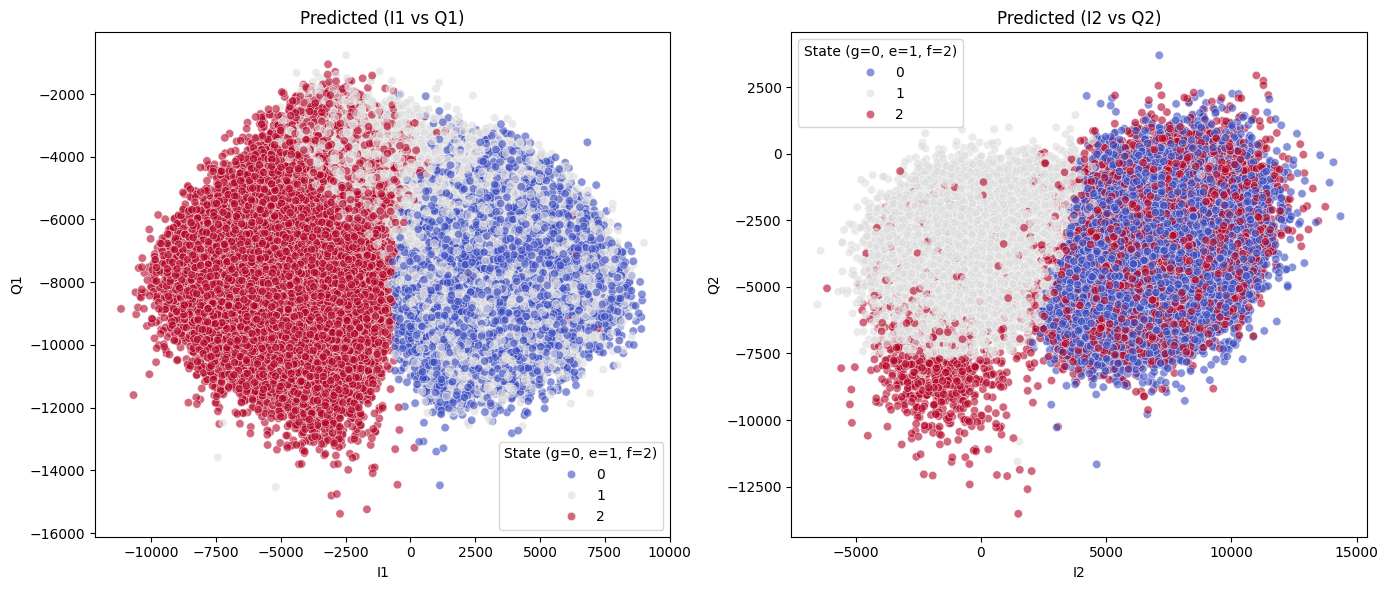

In [8]:
# Convert test data into a DataFrame for easier plotting
test_df = pd.DataFrame(X_test, columns=["I1", "Q1", "I2", "Q2"])
test_df["label"] = y_test  # Add true labels
test_df["predicted"] = y_pred  # Add predicted labels

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: I1 vs Q1
sns.scatterplot(
    data=test_df,
    x="I1",
    y="Q1",
    hue="predicted",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_xlabel("I1")
axes[0].set_ylabel("Q1")
axes[0].set_title("Predicted (I1 vs Q1)")
axes[0].legend(title="State (g=0, e=1, f=2)")

# Second subplot: I2 vs Q2
sns.scatterplot(
    data=test_df,
    x="I2",
    y="Q2",
    hue="predicted",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_xlabel("I2")
axes[1].set_ylabel("Q2")
axes[1].set_title("Predicted (I2 vs Q2)")
axes[1].legend(title="State (g=0, e=1, f=2)")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

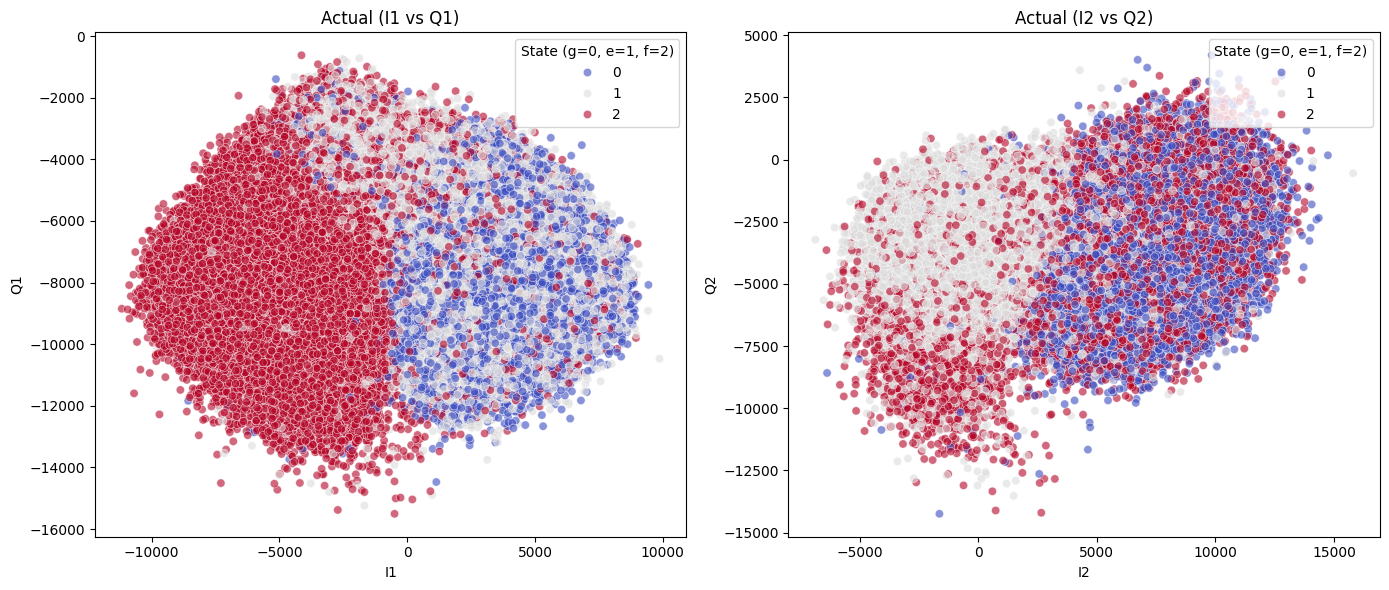

In [9]:
# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: I1 vs Q1
sns.scatterplot(
    data=three_state,
    x="I1",
    y="Q1",
    hue="label",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_xlabel("I1")
axes[0].set_ylabel("Q1")
axes[0].set_title("Actual (I1 vs Q1)")
axes[0].legend(title="State (g=0, e=1, f=2)", loc = 'upper right')

# Second subplot: I2 vs Q2
sns.scatterplot(
    data=three_state,
    x="I2",
    y="Q2",
    hue="label",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_xlabel("I2")
axes[1].set_ylabel("Q2")
axes[1].set_title("Actual (I2 vs Q2)")
axes[1].legend(title="State (g=0, e=1, f=2)", loc = 'upper right')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

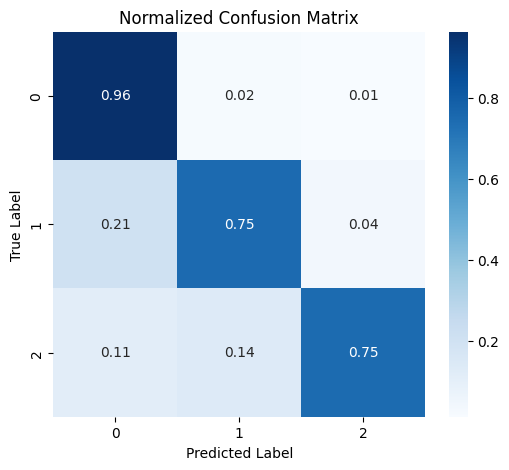

In [11]:
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()